# Load the Data
The training, validation, and test data are in the mat files `news-data-train.mat`, `news-data-val.mat`, and `news-data-test.mat`.
Each file has a dictionary containing a list of article text, article title, and article dateline (location and date).

- `train['txt'][i]` - text for the i-th article in training set
- `train['title'][i]` - title for the i-th article in the training set
- `train['dateline'][i]` - dateline for the i-th article in the training set

And similary for the test and validation data.  The validation data also includes the ground-truth matches:
- `val['gtretr'][i]` - a list of the ground-truth retrieved documents in the training set for the i-th article in the validation set.

The below code will load the data.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import IPython.utils.warn as warn
random.seed(100)
import csv
import nltk
from scipy import io
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# load data
from scipy import io

train = io.loadmat('news-data-train.mat', squeeze_me=True)
test  = io.loadmat('news-data-test.mat', squeeze_me=True)
val   = io.loadmat('news-data-val.mat', squeeze_me=True)

print len(train['txt'])
print len(test['txt'])
print len(val['txt'])

3968
333
84


Show the first article in the training set:

In [3]:
print train['title'][0]
print train['dateline'][0]
print train['txt'][0]

SINGAPORE PETROLEUM CO REVISES PETROL PUMP PRICES          
SINGAPORE, June 1 -                                        
Singapore Petroleum Co Pte Ltd will
revise pump prices of petrol from June 2, an official said.
    Grade 97 octane with 0.15 gm/lead will be 96.8 cents/litre
against 94 cents previously for 0.4 gm lead. Grade 92 octane
will be 90.6 cents against 87.6 previously.
    SPC's price revision follows the Ministry of Trade and
Industry's move to liberalise petrol pricing by allowing oil
companies to set their own pump prices.
    New grades of petrol with lower lead content are sold in
Singapore from today in line with the Ministry of Environment's
regulations.
 REUTER                                                                                                                                                                                                                                                                                                                       

Show the first article in the validation set, along with the indices of the ground-truth retrieved documents from the training set.

In [4]:
print val['title'][0]
print val['dateline'][0]
print val['txt'][0]
print val['gtretr'][0]

WORK ON GREEK ALUMINA PLANT TO START END MAY      
ATHENS, April 13 -              
Preparatory work for construction of a
450 mln dlr alumina plant near the village of Aghia Efthymia in
the Greek province of Fokida will begin at the end of next
month and the plant will be operational by 1992, Industry
Undersecretary George Petsos said.
    Greece yesterday signed contracts with the Soviet Union for
the joint venture project, the biggest investment in the
country for 20 years.
    Petsos said the Soviet Union, which had initially agreed to
buy 380,000 tonnes, would now purchase the plant's entire
output of 600,000 tonnes a year.
 Reuter                                                                                                                                                                                                                                                                                                                                                                    

Here are two helpful functions for doing retrieval, calculating MAP, and writing the Kaggle submission file.

In [5]:
def nn_retr(testX, trainX):
    # do retrieval using nearest neighbors
    # for each entry in testX, find the top 10 closest entries in trainX using Euclidean distance
    
    test_retr = []  # retrieval list

    # for each test document vector
    for tX in testX:
        # calculate the distance between tX and all training document vectors
        # (using Euclidean distance)
        D = metrics.pairwise_distances(tX, trainX, metric='euclidean')
    
        # find the 10 with smallest distance
        bestmatches = argsort(D.flatten())[0:10]
    
        # add to retrieval list
        test_retr.append(bestmatches)

    return test_retr

def calc_MAP(Ytrue, Ypred, K=10):
    # calculate the mean average precision
    # returns the MAP for the whole set, and the AP for each document
    
    AP = zeros(len(Ytrue))
    # for each document
    for j in range(len(Ytrue)):
        Yt = Ytrue[j]
        if not isinstance(Yt, ndarray):
            Yt = array([Yt])
        Yp = Ypred[j]
        # calculate average precision @ K
        nummatches = 0.
        score = 0.
        for i,y in enumerate(Yp[0:K]):
            # if match at this level, calculate P
            if any(y==Yt):
                nummatches += 1.
                P = nummatches / (i+1)
                score += P
        AP[j] = score / min(K, len(Yt))

    # mean over all documents
    MAP = mean(AP)
    return (MAP, AP)

# write a kaggle submission file for retrieval
def write_csv_kaggle_retr_sub(fname, Yretr):
    # header
    tmp = [['Id', 'RetrievedDocuments']]
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yretr)):
        y = Yretr[i]
        ystr = [str(q) for q in y]
        tmp2 = [(i+1)]
        tmp2.append(" ".join(ystr))        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'wb')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

(3968, 1000)
(84, 1000)
(333, 1000)


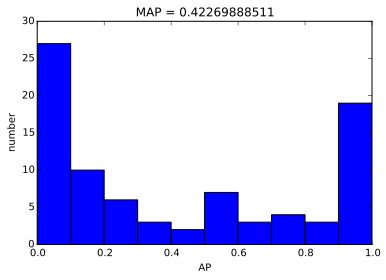

In [6]:
######################baseline##################################
# setup the document vectorizer
cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=1000)

# using the article text create the vocabulary, and return the document vectors
trainX = cntvect.fit_transform(train['txt'])

# convert the validation and test article text
valX   = cntvect.transform(val['txt'])
testX  = cntvect.transform(test['txt'])

print trainX.shape
print valX.shape
print testX.shape

# TF-IDF representation
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True)

# setup the TF-IDF representation, and transform the training set
trainXtf = tf_trans.fit_transform(trainX)

# transform the validation and test set
valXtf  = tf_trans.transform(valX)
testXtf = tf_trans.transform(testX)

# do retrieval for the validation and test set
val_retr  = nn_retr(valXtf, trainXtf)
test_retr = nn_retr(testXtf, trainXtf)

# evaluate the validation set
(MAP, AP) = calc_MAP(val['gtretr'], val_retr)

# show a histogram of AP scores
plt.hist(AP)
plt.title("MAP = " + str(MAP))
plt.xlabel('AP')
plt.ylabel('number')


The validation MAP and test MAP on Kaggle are 0.42269 and 0.42624 respectively.
The baseline vectorizes the text without tuning parameters and removing punctuation.
Therefore I tune the parameter and use a tokenize function to remove the punctuation.

In [7]:
import nltk
from nltk import word_tokenize          
import string
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation]) #move punctuation
    tokens = nltk.word_tokenize(text)
    return tokens

In [8]:
vocas = range(1000,1600,100)
avgscores = empty(len(vocas))
for i,voca in enumerate(vocas): 
    tfvect = feature_extraction.text.TfidfVectorizer(use_idf=True, tokenizer =  tokenize, stop_words = 'english', max_features=voca)
    print voca
    trainXtf = tfvect.fit_transform(train['txt'])
    valXtf   = tfvect.transform(val['txt'])
    val_retr  = nn_retr(valXtf, trainXtf)
    (MAP, AP) = calc_MAP(val['gtretr'], val_retr)
   
    avgscores[i]=MAP

1000
1100
1200
1300
1400
1500


In [11]:
besti = argmax(avgscores)
bestv = vocas[besti]
print "best vocabulary size = ", bestv
print "best MAP = ", avgscores[besti]

best vocabulary size =  1300
best MAP =  0.432859032502


The best size of vocabulary is 1300, and after tokenizing and tuning the vocabulary size, the validation MAP increases to 0.43285.

In [12]:
tfvect = feature_extraction.text.TfidfVectorizer(use_idf=True, tokenizer =  tokenize, stop_words = 'english', max_features=bestv)
trainXtf = tfvect.fit_transform(train['txt'])
valXtf   = tfvect.transform(val['txt'])
testXtf = tfvect.transform(test['txt'])


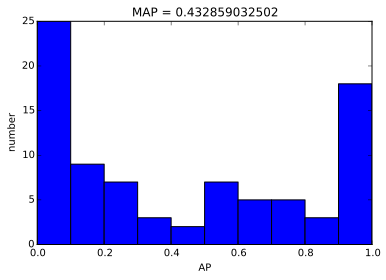

In [13]:
val_retr  = nn_retr(valXtf, trainXtf)
test_retr = nn_retr(testXtf, trainXtf)

# evaluate the validation set
(MAP, AP) = calc_MAP(val['gtretr'], val_retr)

# show a histogram of AP scores
plt.hist(AP)
plt.title("MAP = " + str(MAP))
plt.xlabel('AP')
plt.ylabel('number')

The testing MAP on Kaggle also increases to 0.44724.

I add stemming to see the result.

In [14]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
#import porter
#stemmer=porter.PorterStemmer()
def tokenize_and_stem(text):
    
    text = "".join([ch for ch in text if ch not in string.punctuation]) #move punctuation
    tokens = nltk.word_tokenize(text)
    stems = [stemmer.stem(t) for t in tokens]
    return stems

In [16]:
vocas = range(1000,1600,100)
savgscores = empty(len(vocas))
for i,voca in enumerate(vocas): 
    stfvect = feature_extraction.text.TfidfVectorizer(use_idf=True, tokenizer =  tokenize_and_stem, stop_words = 'english', max_features=voca)
    print voca
    strainXtf = tfvect.fit_transform(train['txt'])
    svalXtf   = tfvect.transform(val['txt'])
    sval_retr  = nn_retr(svalXtf, strainXtf)
    (MAP, AP) = calc_MAP(val['gtretr'], sval_retr)
   
    savgscores[i]=MAP

1000
1100
1200
1300
1400
1500


In [17]:
sbesti = argmax(savgscores)
sbestv = vocas[sbesti]
print "best vocabulary size = ", sbestv
print "best MAP = ", savgscores[sbesti]

best vocabulary size =  1000
best MAP =  0.432859032502


After adding stemming, there is no change in validation MAP, but the testing MAP is a lit bit lower. Therefore I still use the simple tokenizer.

The bag-of-word vectors of documents are high-dimensional vectors. They can be transformed into low-dimensional vectors and each dimension represents similarity to a topic. So it is important to reduce the feature dimensionality.

Non-negative Matrix Factorization (NMF) is able to deal with sparse data while Principal Component Analysis (PCA) cannot, and NMF can constrain the topic vector and weights to be non-negative, better than Latent Semantic Analysis (LSA). Thus I choose NMF to do the dimensionality reduction. After several trying, I choose 150 as the components. 

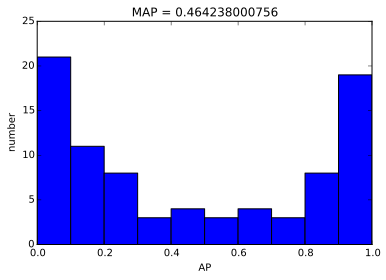

In [18]:
nmf = decomposition.NMF(n_components=150)
trainXnmf = nmf.fit_transform(trainXtf)
valXnmf  = nmf.transform(valXtf)
testXnmf  = nmf.transform(testXtf)

# do retrieval for the validation and test set
val_retr  = nn_retr(valXnmf, trainXnmf)
test_retr = nn_retr(testXnmf, trainXnmf)

# evaluate the validation set
(MAP, AP) = calc_MAP(val['gtretr'], val_retr)

# show a histogram of AP scores
plt.hist(AP)
plt.title("MAP = " + str(MAP))
plt.xlabel('AP')
plt.ylabel('number')

The validation accuracy increases to 0.46423 and the testing accuracy also rises to 0.45794.

Since all the retrieval use Euclidean distance, which is susceptible to documents being clustered by their L2-norm, I'd like to try cosine similarity. Cosine similarity gives a useful measure of how similar two documents are likely to be in terms of their subject matter, so it can help find the top 10 similar articles.

In [19]:
import math
def cs_retr(testX, trainX):
    # do retrieval using nearest neighbors
    # for each entry in testX, find the top 10 closest entries in trainX using cosine distance
    
    test_retr = []  # retrieval list

    # for each test document vector
    for tX in testX:
        # calculate the distance between tX and all training document vectors
        # (using cosine distance)
        cos_sim = cosine_similarity(tX, trainX) #calculate cosine similarity first
        D = 1- cos_sim
    
        # find the 10 with smallest distance
        bestmatches = argsort(D.flatten())[0:10]
    
        # add to retrieval list
        test_retr.append(bestmatches)

    return test_retr

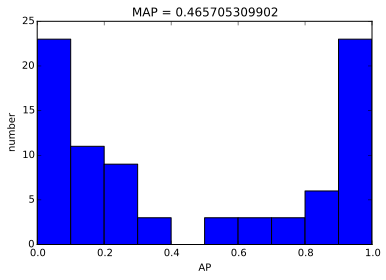

In [21]:
val_retr  = cs_retr(valXnmf, trainXnmf)
test_retr = cs_retr(testXnmf, trainXnmf)

# evaluate the validation set
(MAP, AP) = calc_MAP(val['gtretr'], val_retr)

# show a histogram of AP scores
plt.hist(AP)
plt.title("MAP = " + str(MAP))
plt.xlabel('AP')
plt.ylabel('number')

After using cosine similarity, the validation MAP and tesing MAP increase to 0.46570 and 0.46966 respectively.

In [22]:
# write to test retreival to Kaggle submission file
write_csv_kaggle_retr_sub("news_mytest_sub.csv", test_retr)